In [1]:
import os
import shutil

# Copy dataset from Kaggle input to working folder
src = '/kaggle/input/fer2013-dataset'
dst = '/kaggle/working/fer2013-dataset-copy'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

# Keep only emotions of interest
keep_classes = ['angry', 'happy', 'sad', 'surprise', 'neutral']

def clean_folders(base_dir, keep):
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder not in keep:
            shutil.rmtree(folder_path)

clean_folders(os.path.join(dst, 'train'), keep_classes)
clean_folders(os.path.join(dst, 'test'), keep_classes)


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '/kaggle/working/fer2013-dataset-copy'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

emotions = ['angry', 'happy', 'sad', 'surprise', 'neutral']
img_size = (224, 224)  # Match MobileNetV2 pretrained weights input size
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True, classes=emotions
)

val_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False, classes=emotions
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False, classes=emotions
)


2025-10-16 13:49:11.956284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760622552.235468      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760622552.314372      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 19341 images belonging to 5 classes.
Found 4835 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Multiply, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='selu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

img_size = (224, 224)
emotions = ['angry', 'happy', 'sad', 'surprise', 'neutral']

inputs = Input(shape=(*img_size, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = se_block(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('selu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = Activation('selu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='selu')(x)
outputs = Dense(len(emotions), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


/tmp/ipykernel_19/1476331714.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
I0000 00:00:1760622568.731336      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760622568.732020      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,291,909 (12.56 MB)

 Trainable params: 1,033,541 (3.94 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# Train with frozen base model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze last 60 layers (for stronger fine-tuning)
for layer in model.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model after training
model.save('fer2013_mobilenetv2_se_selu_finetuned.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1760622582.178964      83 service.cc:148] XLA service 0x488ce500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760622582.180311      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760622582.180355      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760622583.253593      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/605 ━━━━━━━━━━━━━━━━━━━━ 2:57:54 18s/step - accuracy: 0.1562 - loss: 2.7044

I0000 00:00:1760622589.771502      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


605/605 ━━━━━━━━━━━━━━━━━━━━ 287s 446ms/step - accuracy: 0.2885 - loss: 1.8033 - val_accuracy: 0.4159 - val_loss: 1.4344 - learning_rate: 1.0000e-04
Epoch 2/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 255s 422ms/step - accuracy: 0.3982 - loss: 1.4570 - val_accuracy: 0.4281 - val_loss: 1.4130 - learning_rate: 1.0000e-04
Epoch 3/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 255s 422ms/step - accuracy: 0.4455 - loss: 1.4053 - val_accuracy: 0.4347 - val_loss: 1.3961 - learning_rate: 1.0000e-04
Epoch 4/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 257s 425ms/step - accuracy: 0.4499 - loss: 1.3825 - val_accuracy: 0.4581 - val_loss: 1.3857 - learning_rate: 1.0000e-04
Epoch 5/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 253s 418ms/step - accuracy: 0.4683 - loss: 1.3647 - val_accuracy: 0.4900 - val_loss: 1.3342 - learning_rate: 1.0000e-04
Epoch 6/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 254s 420ms/step - accuracy: 0.4795 - loss: 1.3394 - val_accuracy: 0.4805 - val_loss: 1.3366 - learning_rate: 1.0000e-04
Epoch 7/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 254s 420ms/

152/152 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - accuracy: 0.6088 - loss: 1.1142


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6286 - loss: 1.0735
Validation Accuracy: 63.76%
Test Accuracy: 65.91%
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.47      0.53       958
       happy       0.80      0.83      0.82      1774
         sad       0.51      0.53      0.52      1247
    surprise       0.80      0.75      0.77       831
     neutral       0.56      0.62      0.59      1233

    accuracy                           0.66      6043
   macro avg       0.65      0.64      0.65      6043
weighted avg       0.66      0.66      0.66      6043



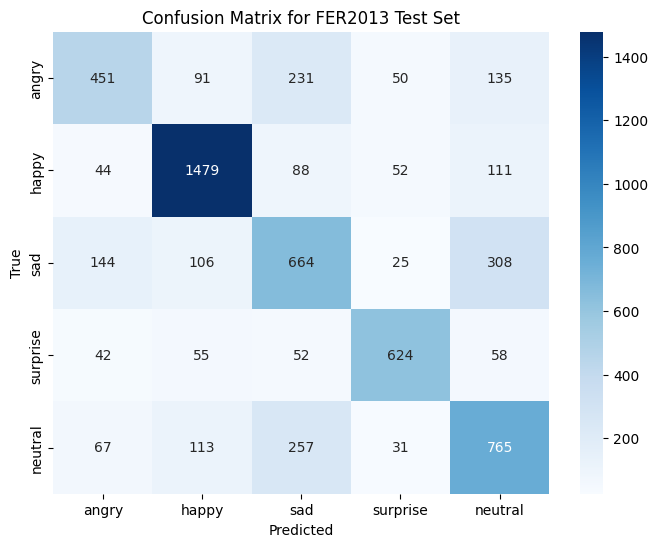

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load model if starting fresh
from tensorflow.keras.models import load_model
model = load_model('fer2013_mobilenetv2_se_selu_finetuned.keras')

# Evaluate on validation and test sets
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Predictions for detailed metrics
test_data.reset()
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for FER2013 Test Set')
plt.show()
